# Rieke Manookin lab DataJoint tutorial
March 2024

Vyom Raval

Make sure your docker container is running with the terminal command `docker compose up -d`

In [3]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob

import sys
sys.path.append('/Users/riekelabbackup/Desktop/Vyom/gitrepos/samarjit_datajoint/next-app/api/')
import schema
import helpers.pop as pop


import pandas as pd
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp
import djutils as dju

Let's connect to the datajoint server hosted in our docker container.

In [2]:
host_address, user, password = '127.0.0.1', 'root', 'simple'
dj.config["database.host"] = f"{host_address}"
dj.config["database.user"] = f"{user}"
dj.config["database.password"] = f"{password}"
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

Define paths to data, and load in any new data.

In [4]:
db = dj.VirtualModule('schema.py', 'schema')
data_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data'
meta_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta'
tags_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags'
username = 'vyomr'
pop.append_data(data_dir, meta_dir, tags_dir, username, db)

  0%|          | 0/3 [00:00<?, ?it/s]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/led_sawtooth_calibrations_20250210C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/led_sine_calibration_20250207C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20240229C.json


100%|██████████| 3/3 [00:00<00:00, 40.87it/s]


0

## Intro to the database
The database consists of a `schema` which relates different data tables together. We can visualize the entire schema, and peek at different tables to see what's going on.

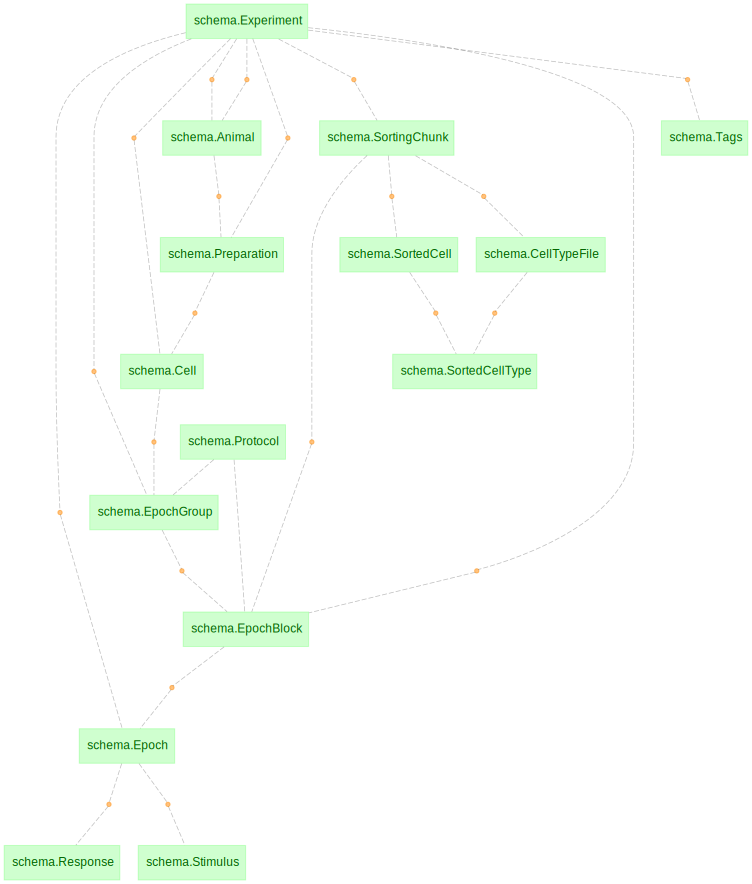

In [5]:
dj.Diagram(schema)

That's a lot to take in. Feel free to step through each table to see what's going on. I'll illustrate ways to look at the tables and fetch their data with the Experiment table.

In [13]:
schema.Experiment()

id,h5_uuid,exp_name,meta_file,"data_file empty if MEA for now, maybe should store ""/Volumes/data/data/sorted"" here?",tags_file,"is_mea 1 if MEA, 0 if not",date_added,label,properties,attributes,start_time,experimenter,institution,lab,project,rig,rig_type
1,dca776e2-28bf-4fe0-a603-33b2b78a2311,led_sawtooth_calibrations_20250210C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/led_sawtooth_calibrations_20250210C.json,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/led_sawtooth_calibrations_20250210C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/led_sawtooth_calibrations_20250210C.json,0,2025-03-14 16:25:31,20250210C,=BLOB=,=BLOB=,2025-02-10 17:22:02,None,None,None,None,None,PATCH
2,49cfe405-db8d-4e9a-8067-e8b535260898,led_sine_calibration_20250207C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/led_sine_calibration_20250207C.json,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/led_sine_calibration_20250207C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/led_sine_calibration_20250207C.json,0,2025-03-14 16:25:31,20250207C,=BLOB=,=BLOB=,2025-02-07 15:49:48,None,None,None,None,None,PATCH
3,365a7ead-5a49-4b27-be9c-9064156284bd,20240229C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20240229C.json,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/20240229C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20240229C.json,1,2025-03-14 16:25:33,20240229,=BLOB=,=BLOB=,2024-02-29 07:23:44,None,None,None,None,None,MEA


In [15]:
df = schema.Experiment().fetch(format='frame').reset_index()
df.head()

,id,h5_uuid,exp_name,meta_file,data_file,tags_file,is_mea,date_added,label,properties,attributes,start_time,experimenter,institution,lab,project,rig,rig_type
0,1,dca776e2-28bf-4fe0-a603-33b2b78a2311,led_sawtooth_calibrations_20250210C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,0,2025-03-14 16:25:31,20250210C,"{'id': '0', 'age': None, 'sex': None, 'weight'...",{'uuid': 'dca776e2-28bf-4fe0-a603-33b2b78a2311...,2025-02-10 17:22:02,None,None,None,None,None,PATCH
1,2,49cfe405-db8d-4e9a-8067-e8b535260898,led_sine_calibration_20250207C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,0,2025-03-14 16:25:31,20250207C,"{'id': None, 'age': None, 'sex': None, 'weight...",{'uuid': '49cfe405-db8d-4e9a-8067-e8b535260898...,2025-02-07 15:49:48,None,None,None,None,None,PATCH
2,3,365a7ead-5a49-4b27-be9c-9064156284bd,20240229C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,1,2025-03-14 16:25:33,20240229,"{'id': 'Z14095', 'age': '9 yr 11 mo', 'sex': '...",{'uuid': '365a7ead-5a49-4b27-be9c-9064156284bd...,2024-02-29 07:23:44,None,None,None,None,None,MEA


When pulling as a pandas dataframe, it's generally helpful to call `reset_index` so you end up with a single 0-based index.

## Querying Workflow
You shouldn't need to step through individual tables for a typical workflow, as there should be utility functions for desired steps. If there isn't a function, help us make one to the repo!

In [56]:
import importlib
importlib.reload(dju)
exp_name = '20240229C'
df = dju.mea_exp_summary(exp_name)
df.head()

,data_dir,group_label,NDF,chunk_name,protocol_name,experiment_id,group_id,block_id,chunk_id,protocol_id
0,20240229C/data000,noise 3K,1.0,chunk1,manookinlab.protocols.SpatialNoise,3,13,13,3,3
1,20240229C/data001,DOVES 3K,1.0,chunk2,manookinlab.protocols.DovesMovie,3,14,14,1,4
2,20240229C/data002,DOVES 13K,0.5,chunk2,manookinlab.protocols.DovesMovie,3,15,15,1,4
3,20240229C/data003,DOVES 40K,0.0,chunk2,manookinlab.protocols.DovesMovie,3,16,16,1,4
4,20240229C/data004,noise,0.5,chunk2,manookinlab.protocols.SpatialNoise,3,17,17,1,3


This lets me see a nice summary of an MEA experiment day. 

Let's query for a specific protocol.

In [49]:
import importlib
importlib.reload(dju)
ls_protocols = dju.search_protocol('doves')
print(ls_protocols)

['manookinlab.protocols.DovesMovie']


Get associated metadata for this protocol.

In [ ]:
import importlib
importlib.reload(dju)
df_meta = dju.mea_meta_from_protocols(ls_protocols)
df_meta

,data_dir,group_label,NDF,chunk_name,protocol_name,exp_name,is_mea,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20240229C/data001,DOVES 3K,1.0,chunk2,manookinlab.protocols.DovesMovie,20240229C,1,3,4,14,14,1
1,20240229C/data002,DOVES 13K,0.5,chunk2,manookinlab.protocols.DovesMovie,20240229C,1,3,4,15,15,1
2,20240229C/data003,DOVES 40K,0.0,chunk2,manookinlab.protocols.DovesMovie,20240229C,1,3,4,16,16,1
3,20240229C/data013,doves full ndf0,0.0,doves,manookinlab.protocols.DovesMovie,20240229C,1,3,4,25,26,7
4,20240229C/data014,doves full ndf0,0.0,doves,manookinlab.protocols.DovesMovie,20240229C,1,3,4,25,27,7


Get any associated cell typing for these sorting chunks.

In [88]:
import importlib
importlib.reload(dju)
df_ct = dju.cell_typing_from_chunks(df_meta['chunk_id'])
df_ct

,exp_name,chunk_name,algorithm,typing_file_name,total_clusters,OffP,OffM,OnP,OnM,SBC,typing_file_id,experiment_id,chunk_id
0,20240229C,chunk2,kilosort2,kilosort2.classification.txt,693,98,76,65,104,31,1,3,1
1,20240229C,chunk2,kilosort2,kilosort2.salb.classification.txt,693,98,76,65,104,31,2,3,1


Plot mosaics for queried datasets.

Loading STA from /Volumes/data-1/analysis/20240229C/chunk2/kilosort2/kilosort2.params...
Loaded STA for 693 cells.
Loading STA from /Volumes/data-1/analysis/20240229C/chunk2/kilosort2/kilosort2.params...
Loaded STA for 693 cells.


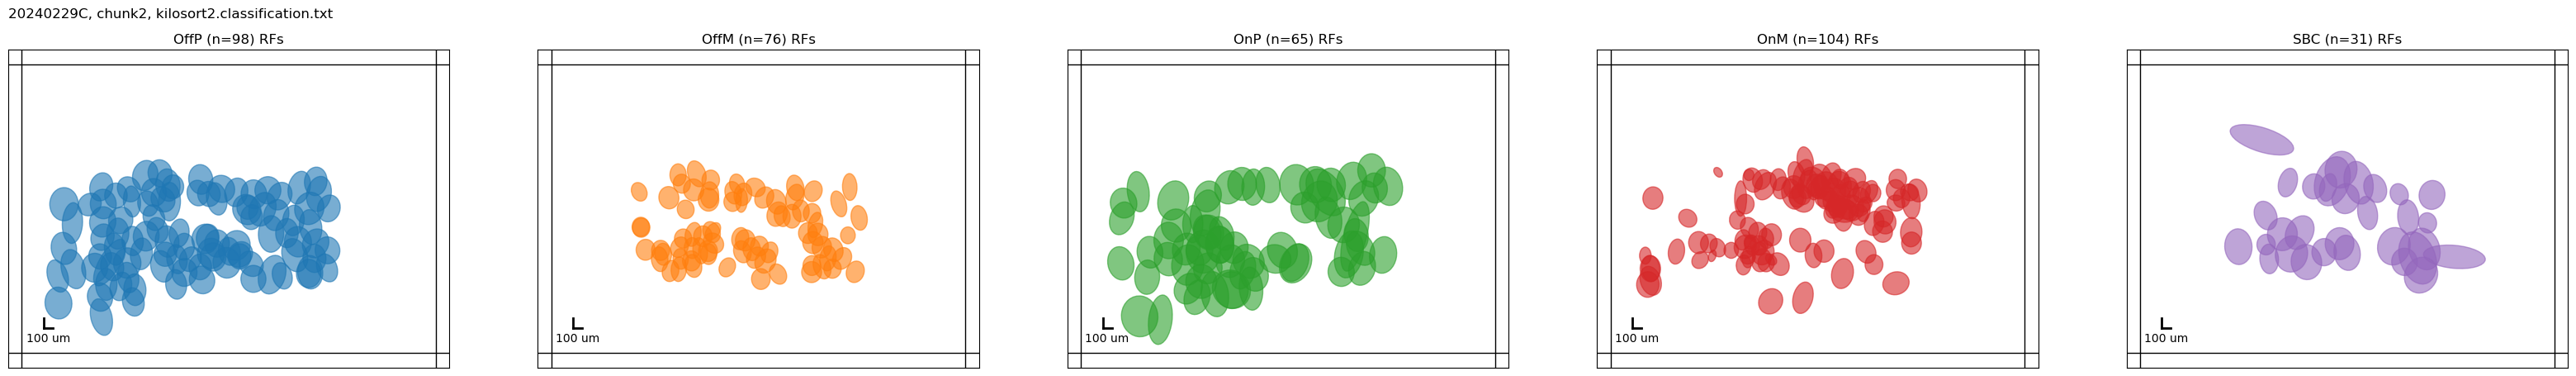

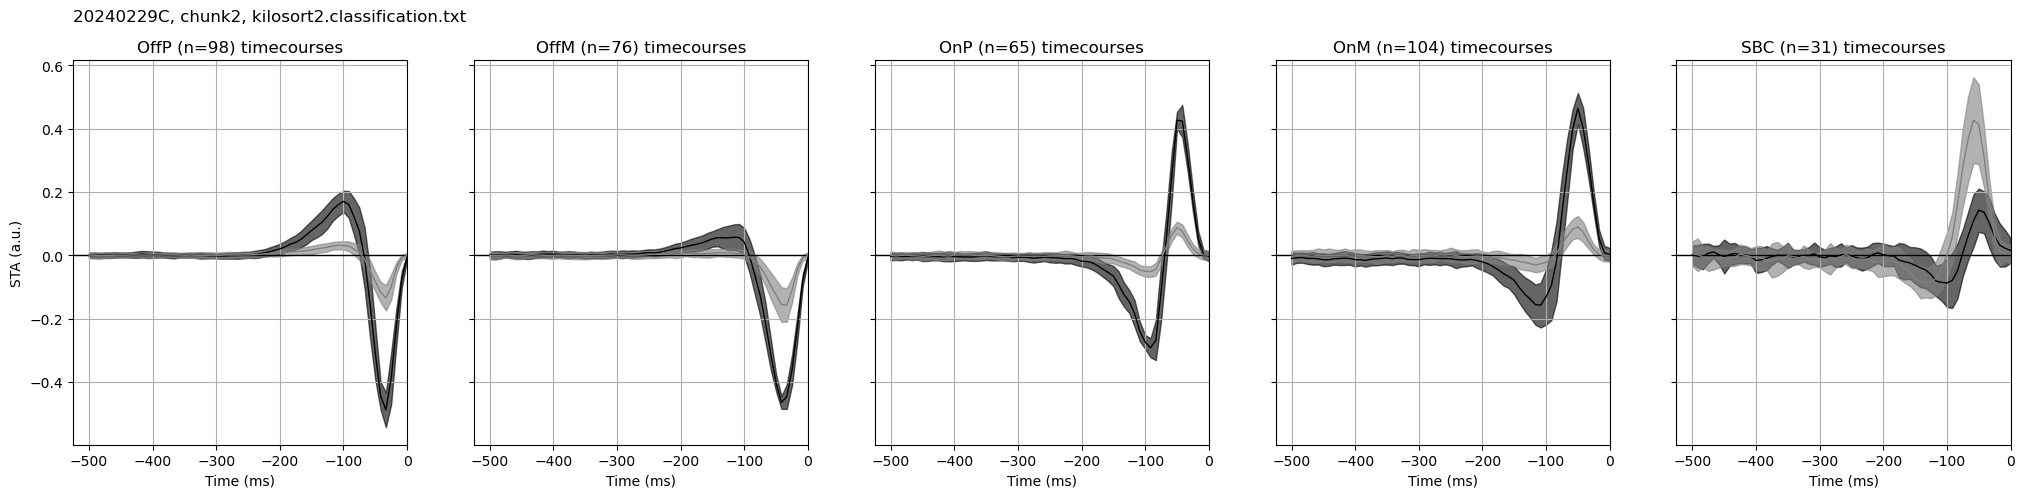

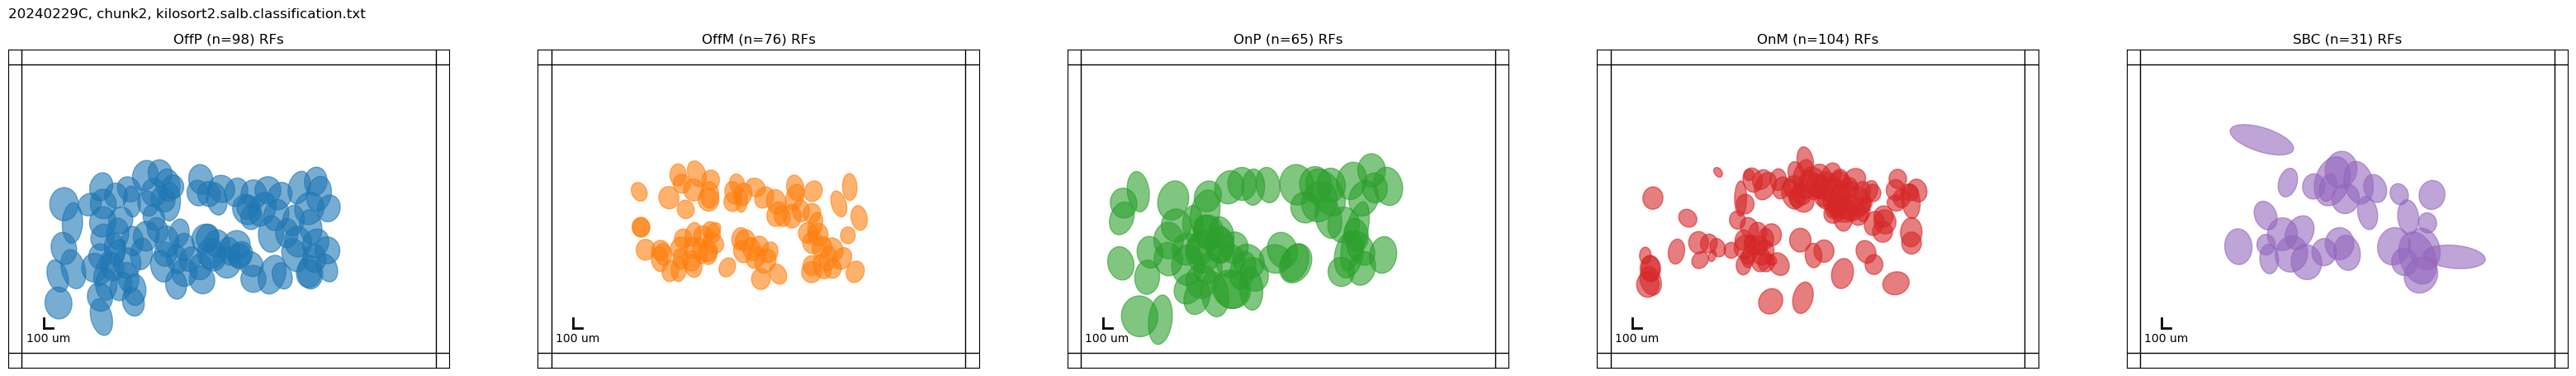

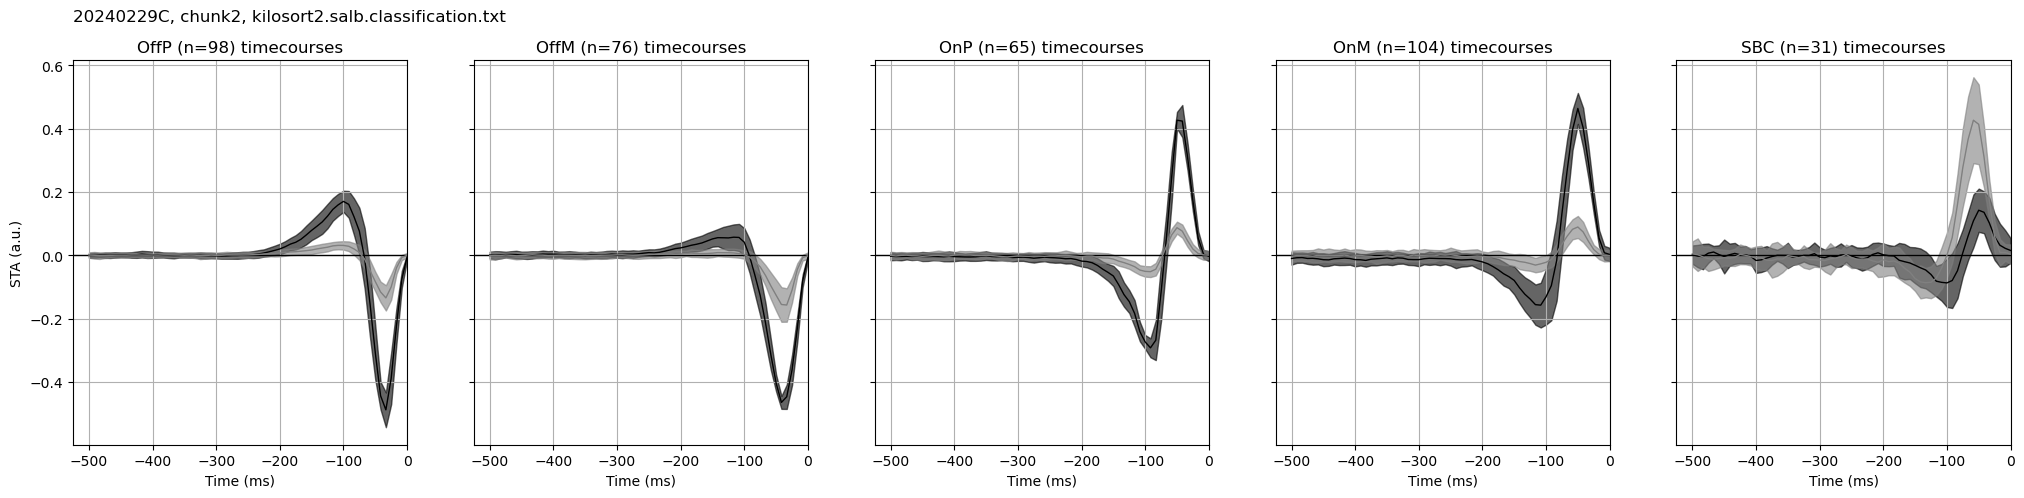

In [95]:
import importlib
importlib.reload(dju)
df_data = dju.mosaics_from_typing(df_ct)

Epoch level parameter queries

Compute an analysis value for cells across queried datasets.